In [3]:
import os
import gc
import random
import requests
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
print(plt.style.available)
import seaborn as sns
plt.style.use('seaborn-v0_8')
from PIL import Image
from tqdm import tqdm
from scipy import stats
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoConfig, AutoModel, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

import warnings
warnings.simplefilter('ignore')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [50]:
class CONFIG:
    seed=2022
    num_fold = 5
    model = 'anferico/bert-for-patents'
    max_len = 16
    train_batch_size = 16
    valid_batch_size = 32
    test_batch_size = 36
    epochs = 2
    learning_rate = 1e-5
    scheduler = 'linear'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

CONFIG.tokenizer = AutoTokenizer.from_pretrained(CONFIG.model)

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(CONFIG.seed)

In [6]:
train = pd.read_csv(os.getcwd() + '/Data/train.csv')
test = pd.read_csv(os.getcwd() + '/Data/test.csv')
sub = pd.read_csv(os.getcwd() + '/Data/sample_submission.csv')

In [7]:
train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36473 entries, 0 to 36472
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       36473 non-null  object 
 1   anchor   36473 non-null  object 
 2   target   36473 non-null  object 
 3   context  36473 non-null  object 
 4   score    36473 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.4+ MB


Number of Rows having a score of 0 - 7471
Number of Rows having score greater than 0 - 29002


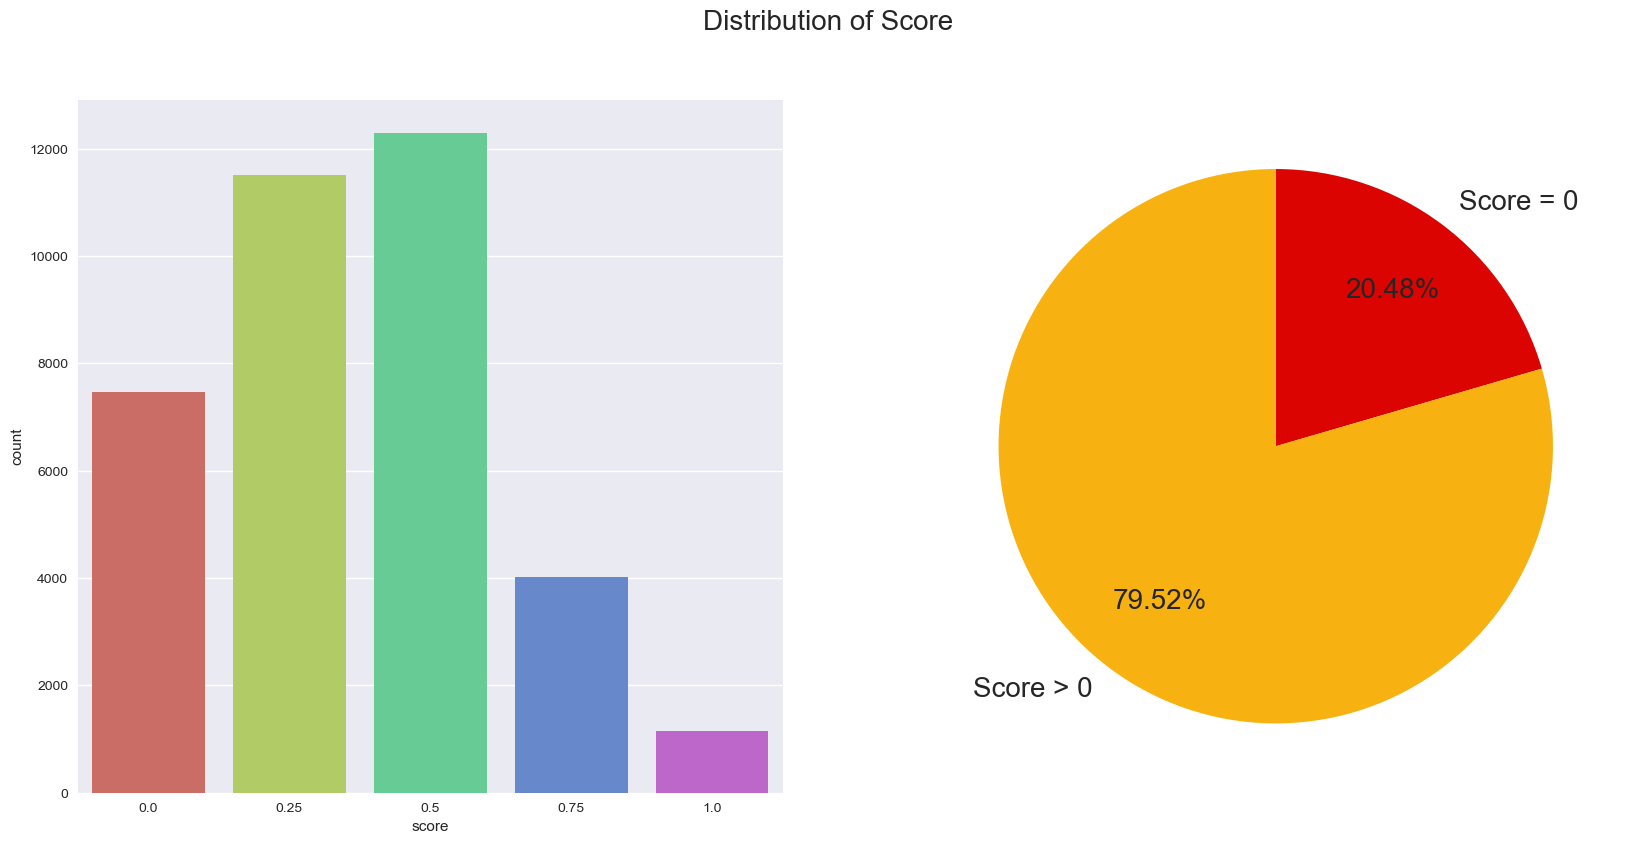

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 9))
fig.suptitle('Distribution of Score', size=20)

sns.countplot(x='score', data=train, palette='hls', ax=ax[0])

sizes = []
no_annotations = len(train[train['score']==0])
sizes.append(no_annotations)
annotated = len(train[train['score']!=0])
sizes.append(annotated)

print('Number of Rows having a score of 0 -', no_annotations)
print('Number of Rows having score greater than 0 -', annotated)

labels = ['Score = 0', 'Score > 0']
colors = ['#db0400', '#f7b211']
ax[1].pie(sizes, colors=colors, startangle=90, labels=labels,
        autopct='%.2f%%', pctdistance=0.7,textprops={'fontsize':20}, counterclock=False)

plt.show()

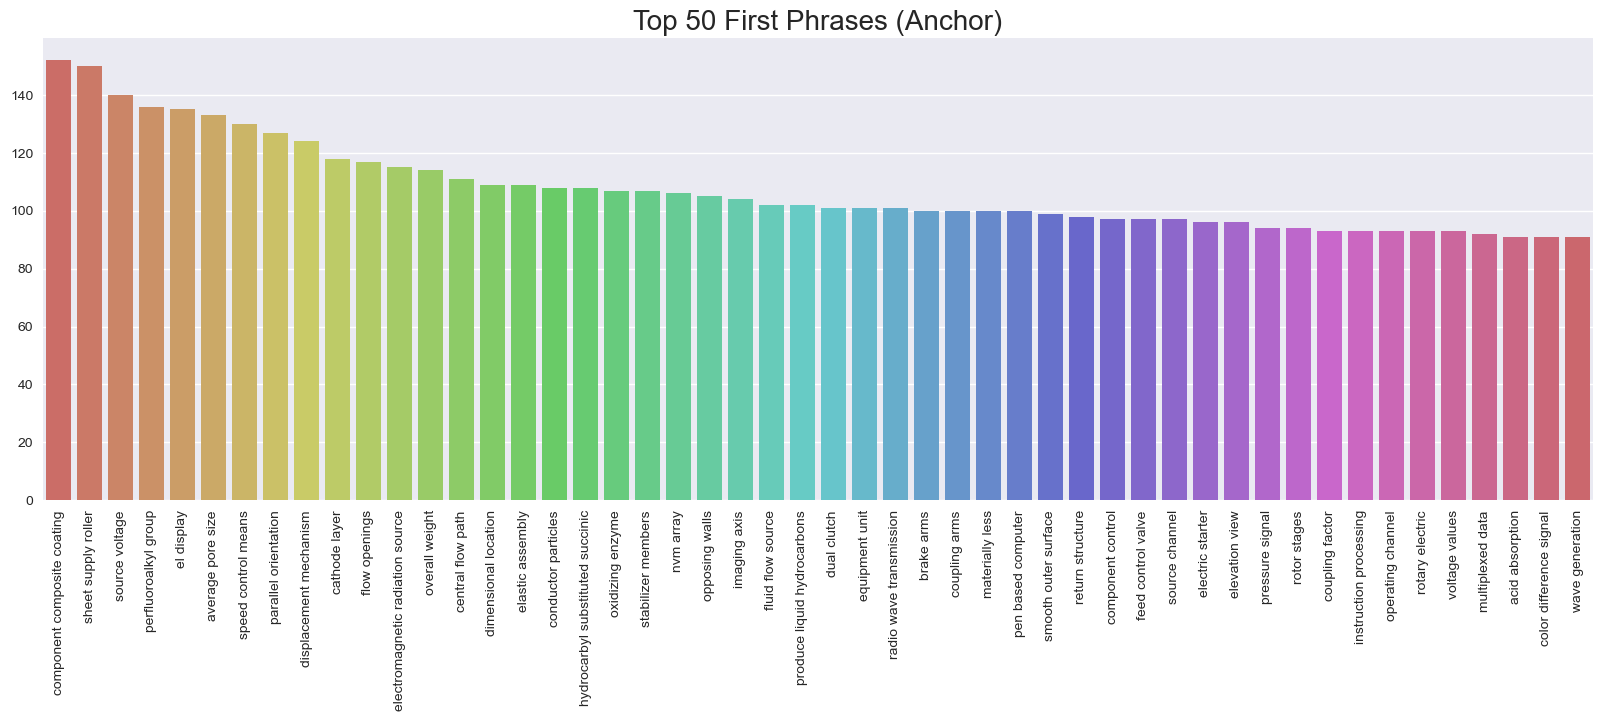

In [12]:
top = Counter([anc for anc in train['anchor']])

top = dict(top.most_common(50))

plt.figure(figsize=(20, 6))

sns.barplot(x=list(top.keys()), y=list(top.values()), palette='hls')
plt.xticks(rotation=90)
plt.title("Top 50 First Phrases (Anchor)", fontsize=20)

plt.show()

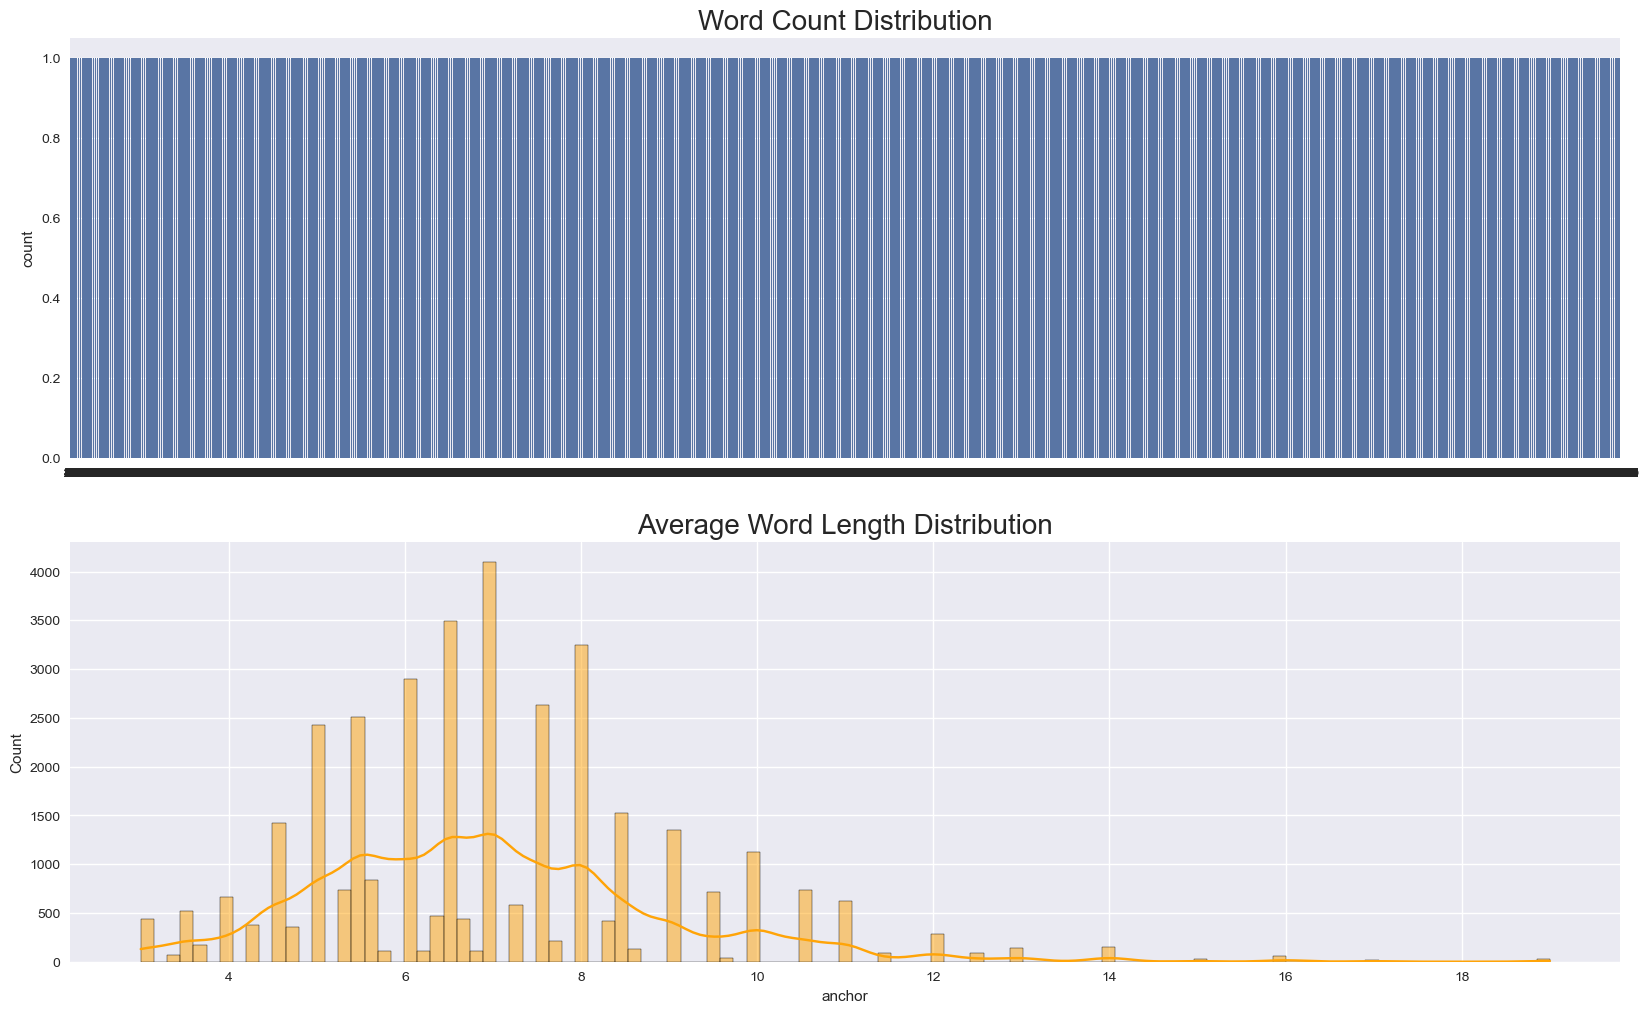

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

text_len = train['anchor'].str.split().map(lambda x : len(x))

sns.countplot(text_len, ax=ax[0])
ax[0].set_title("Word Count Distribution", size=20)

avg_word_len = train['anchor'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x : np.mean(x))
sns.histplot(avg_word_len, ax=ax[1], kde=True, color='#ffa408')
ax[1].set_title('Average Word Length Distribution', size=20)

plt.show()

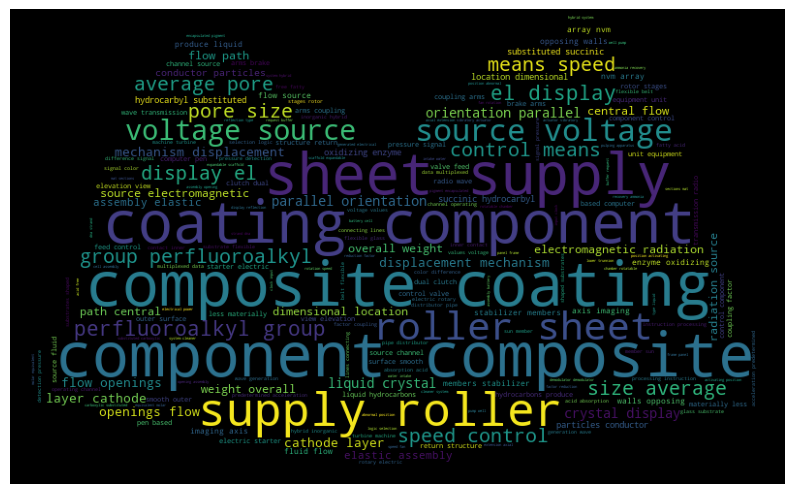

In [14]:
plt.figure(figsize=(10, 10))
text = train['anchor'].values
url = 'https://static.vecteezy.com/system/resources/previews/000/263/280/non_2x/vector-open-book.jpg'
im = np.array(Image.open(requests.get(url, stream=True).raw))
cloud = WordCloud(stopwords = STOPWORDS,
                  background_color='black',
                  mask = im,
                  max_words = 200,
                  ).generate(" ".join(text))
plt.imshow(cloud)
plt.axis('off')
plt.show()

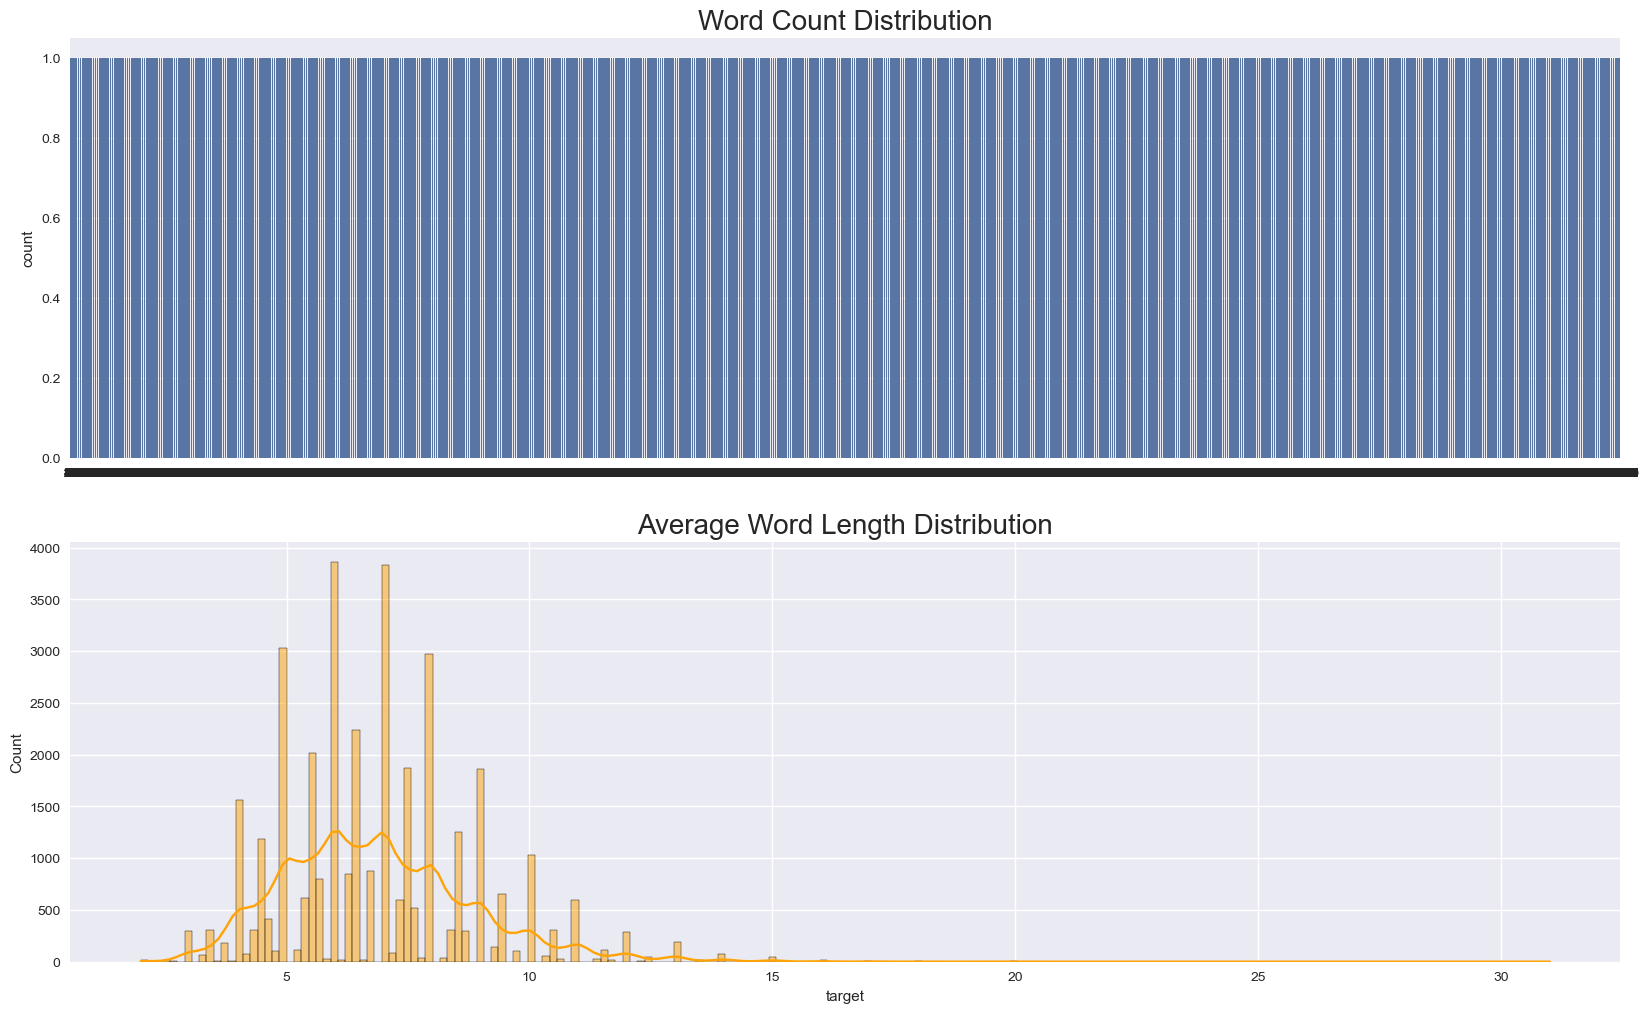

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

text_len = train['target'].str.split().map(lambda x : len(x))

sns.countplot(text_len, ax=ax[0])
ax[0].set_title("Word Count Distribution", size=20)

avg_word_len = train['target'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x : np.mean(x))
sns.histplot(avg_word_len, ax=ax[1], kde=True, color='#ffa408')
ax[1].set_title('Average Word Length Distribution', size=20)

plt.show()

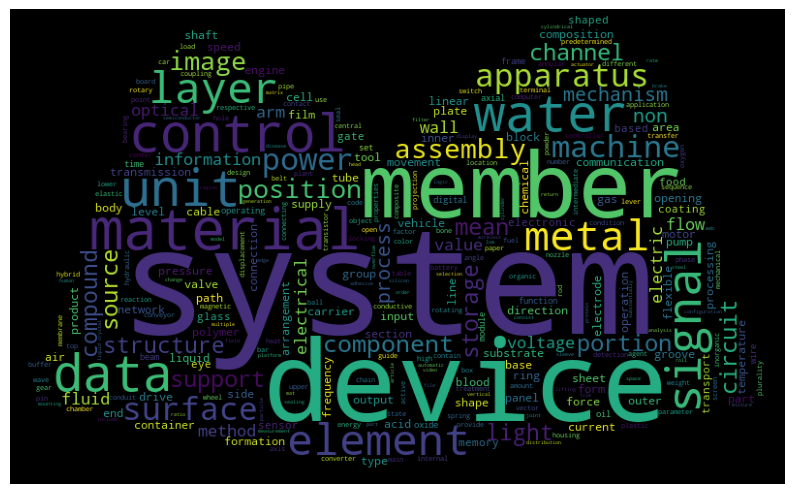

In [16]:
plt.figure(figsize=(10, 10))
text = train['target'].values
url = 'https://static.vecteezy.com/system/resources/previews/000/263/280/non_2x/vector-open-book.jpg'
im = np.array(Image.open(requests.get(url, stream=True).raw))
cloud = WordCloud(stopwords = STOPWORDS,
                  background_color='black',
                  mask = im,
                  max_words = 300,
                  ).generate(" ".join(text))
plt.imshow(cloud)
plt.axis('off')
plt.show()

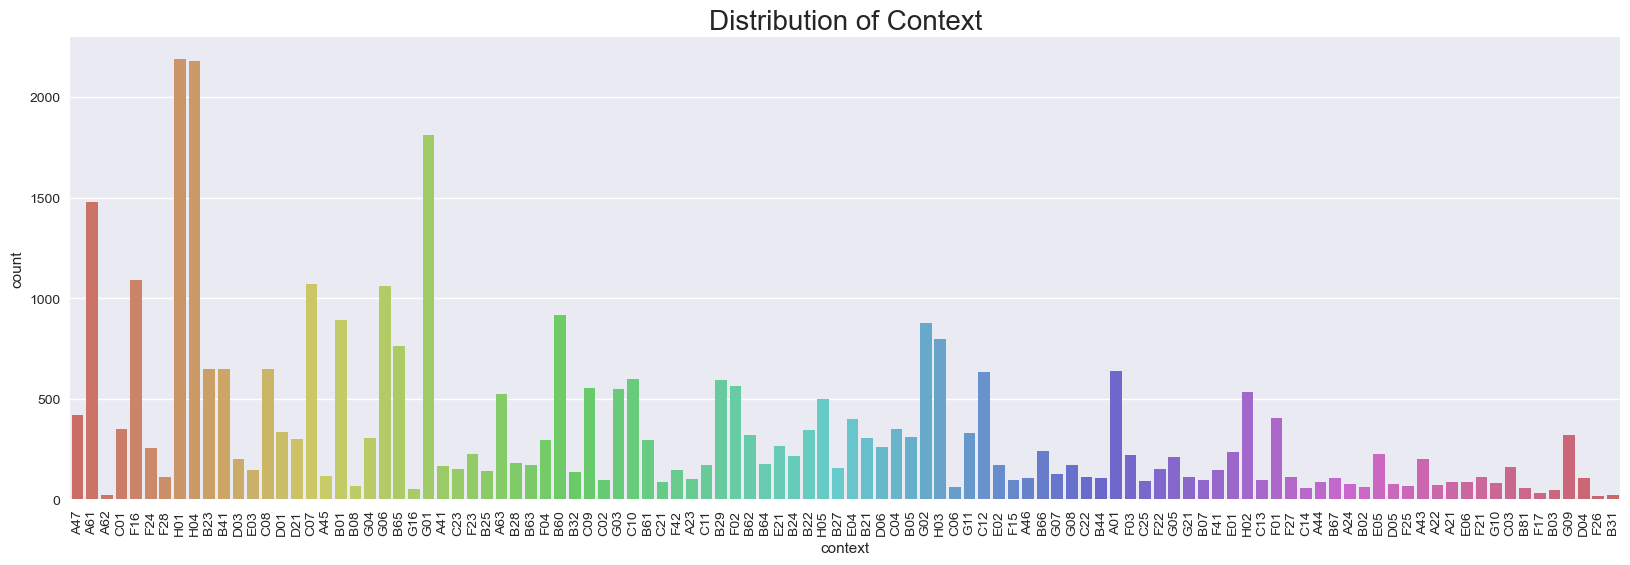

In [17]:
plt.figure(figsize=(20, 6))

sns.countplot(x='context', data=train, palette='hls')
plt.xticks(rotation=90)
plt.title("Distribution of Context", fontsize=20)

plt.show()

In [8]:
train['section'] = train['context'].astype(str).str[0]
train['classes'] = train['context'].astype(str).str[1:]

sections = {"A" : "A - Human Necessities", 
            "B" : "B - Operations and Transport",
            "C" : "C - Chemistry and Metallurgy",
            "D" : "D - Textiles",
            "E" : "E - Fixed Constructions",
            "F" : "F- Mechanical Engineering",
            "G" : "G - Physics",
            "H" : "H - Electricity",
            "Y" : "Y - Emerging Cross-Sectional Technologies"}

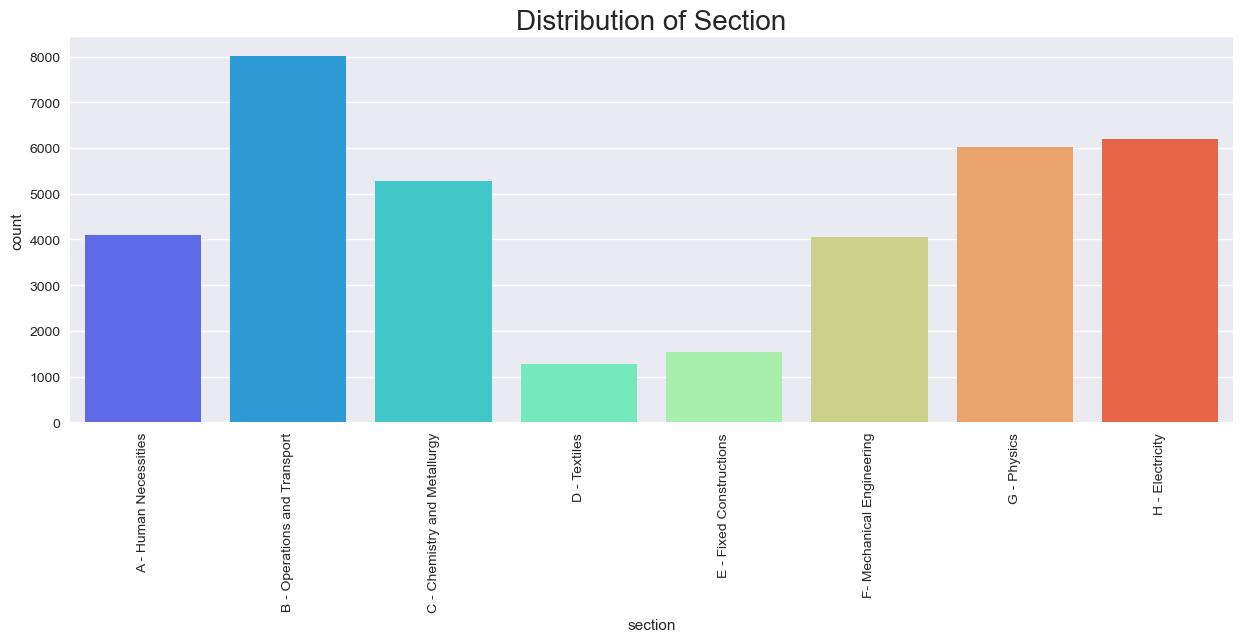

In [19]:
plt.figure(figsize=(15, 5))

sns.countplot(x='section', data=train, palette='rainbow', order = list(sections.keys())[:-1])
plt.xticks([0, 1,2, 3, 4, 5, 6, 7], list(sections.values())[:-1], rotation='vertical')
plt.title("Distribution of Section", fontsize=20)

plt.show()

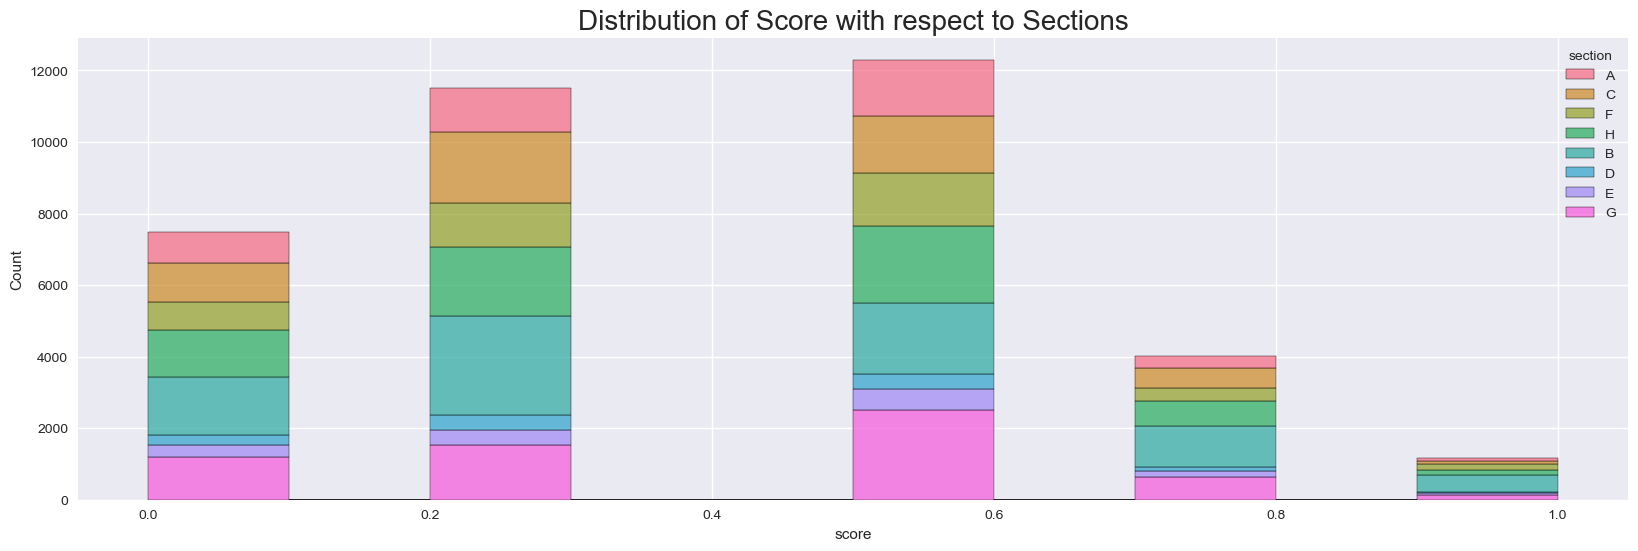

In [20]:
plt.figure(figsize=(20, 6))

sns.histplot(x='score', hue='section', data=train, bins=10, multiple="stack")
plt.title("Distribution of Score with respect to Sections", fontsize=20)

plt.show()

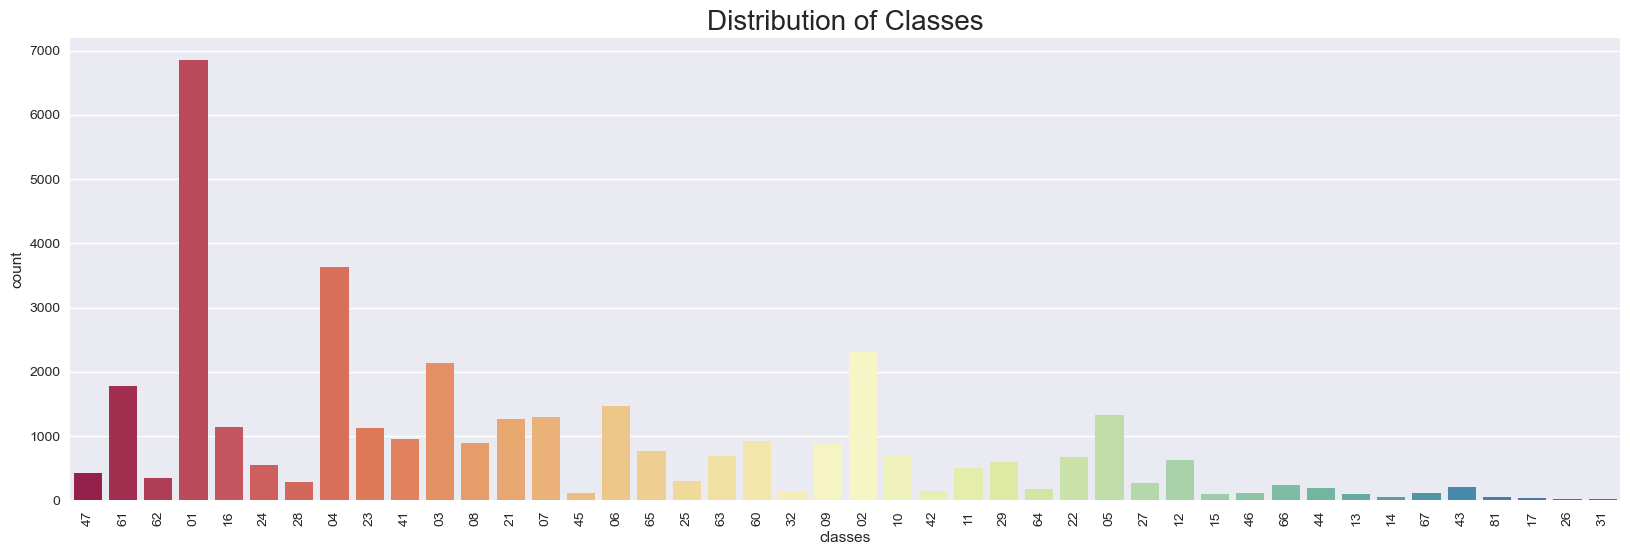

In [21]:
plt.figure(figsize=(20, 6))

sns.countplot(x='classes', data=train, palette='Spectral')
plt.xticks(rotation=90)
plt.title("Distribution of Classes", fontsize=20)

plt.show()

In [9]:
df_cpc = pd.read_csv(os.getcwd() + '/Data/titles.csv')
df_cpc.head(5)

,code,title,section,class,subclass,group,main_group
0,A,HUMAN NECESSITIES,A,NaN,NaN,NaN,NaN
1,A01,AGRICULTURE; FORESTRY; ANIMAL HUSBANDRY; HUNTI...,A,1.0,NaN,NaN,NaN
2,A01B,SOIL WORKING IN AGRICULTURE OR FORESTRY; PARTS...,A,1.0,B,NaN,NaN
3,A01B1/00,Hand tools (edge trimmers for lawns A01G3/06 ...,A,1.0,B,1.0,0.0
4,A01B1/02,Spades; Shovels {(hand-operated dredgers E02F3...,A,1.0,B,1.0,2.0


In [10]:
train['title'] = train['context'].map(df_cpc.set_index('code')['title']).str.lower()

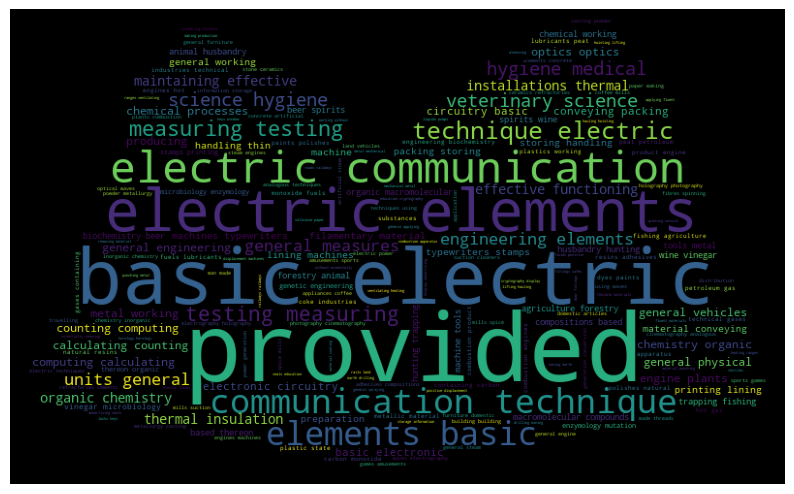

In [24]:
plt.figure(figsize=(10, 10))
text = train['title'].values
url = 'https://static.vecteezy.com/system/resources/previews/000/263/280/non_2x/vector-open-book.jpg'
im = np.array(Image.open(requests.get(url, stream=True).raw))
cloud = WordCloud(stopwords = STOPWORDS,
                  background_color='black',
                  mask = im,
                  max_words = 200,
                  ).generate(" ".join(text))
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [11]:
encoder = LabelEncoder()
train['score_encoded'] = encoder.fit_transform(train['score'])

skf = StratifiedKFold(n_splits=CONFIG.num_fold, shuffle=True, random_state=CONFIG.seed)

for k, (_, val_ind) in enumerate(skf.split(X=train, y=train['score_encoded'])):
    train.loc[val_ind, 'fold'] = k

In [13]:
class USPatentDataset(Dataset):
    def __init__(self, df):
        self.anchor = df['anchor']
        self.target = df['target']
        self.score = df['score']
        
    def __len__(self):
        return len(self.anchor)
    
    def __getitem__(self, index):
        anchor = self.anchor[index]
        target = self.target[index]
        score = self.score[index]
        
        inputs = CONFIG.tokenizer(anchor, target, padding='max_length', max_length=CONFIG.max_len, truncation=True)
        
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]
        
        return {
            "ids": torch.tensor(input_ids, dtype=torch.long),
            "mask": torch.tensor(attention_mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "label": torch.tensor(score, dtype=torch.float),
        }

In [14]:
class USPatentModel(nn.Module):
    def __init__(self):
        super(USPatentModel, self).__init__()
        
        config = AutoConfig.from_pretrained(CONFIG.model)
        
        self.bert = AutoModel.from_pretrained(CONFIG.model, config=config)
        self.drop = nn.Dropout(0.2)
        self.output = nn.Linear(config.hidden_size, 1)
        
    def forward(self, *inputs):
        x = self.bert(*inputs)[1]
        x = self.drop(x)
        x = self.output(x)
        
        return x

In [45]:
class USPatentDataset_Inference(Dataset):
    def __init__(self, df):
        self.anchor = df['anchor']
        self.target = df['target']
        
    def __len__(self):
        return len(self.anchor)
    
    def __getitem__(self, index):
        anchor = self.anchor[index]
        target = self.target[index]
        
        inputs = CONFIG.tokenizer(anchor, target, padding='max_length', max_length=CONFIG.max_len, truncation=True)
        
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]
        
        return {
            "ids": torch.tensor(input_ids, dtype=torch.long),
            "mask": torch.tensor(attention_mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
        }

In [46]:
# Function to get data according to the folds
def get_data(fold):
    train_df = train[train['fold'] != fold].reset_index(drop=True)
    valid_df = train[train['fold'] == fold].reset_index(drop=True)
    
    train_dataset = USPatentDataset(train_df)
    valid_dataset = USPatentDataset(valid_df)
    
    train_loader = DataLoader(train_dataset, batch_size=CONFIG.train_batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG.valid_batch_size, shuffle=False)
    
    return train_loader, valid_loader

def get_inf_data():
    test_dataset = USPatentDataset_Inference(test)
    
    test_loader = DataLoader(test_dataset, batch_size=CONFIG.test_batch_size, shuffle=False)
    
    return test_loader

def loss_fn(outputs, labels):
    return nn.MSELoss()(outputs, labels)

def compute_pearson(outputs, labels):
    # Squash values between 0 to 1
    outputs[outputs < 0] = 0
    outputs[outputs > 1] = 1
    
    # Round off to nearest 0.25 factor
    outputs = 0.25 * np.round(outputs/0.25) 
    
    pearsonr = stats.pearsonr(outputs, labels)[0]
    return pearsonr

def get_optimizer(model):
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {
            "params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            "weight_decay": 0.01
        },
        {
            "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0
        },
    ]

    optimizer = AdamW(optimizer_parameters, lr=CONFIG.learning_rate)

    return optimizer

def get_scheduler(cfg, optimizer, train_loader):
    if cfg.scheduler == 'linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int((len(train_loader)*CONFIG.epochs*6)/100),
            num_training_steps=CONFIG.epochs*len(train_loader),
        )
    elif cfg.scheduler == 'cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int((len(train_loader)*CONFIG.epochs*6)/100),
            num_training_steps=CONFIG.epochs*len(train_loader),
        )
    return scheduler

In [48]:
def train_fn(model, data_loader, optimizer, scheduler, device, epoch):
    model.train()
    
    running_loss = 0
    preds = []
    label=[]
    progress_bar = tqdm(data_loader, position=0)
    
    for step, data in enumerate(progress_bar):
        ids = data['ids'].to(device)
        masks = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        labels = data['label'].to(device)
        
        outputs = model(ids, masks, token_type_ids)
        loss = loss_fn(outputs.view(-1, 1), labels.view(-1, 1))
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if scheduler is not None:
            scheduler.step()
        
        running_loss += loss.item()
        
        preds.extend(outputs.view(-1).cpu().detach().numpy())
        label.extend(labels.view(-1).cpu().detach().numpy())
        
        progress_bar.set_description(f"Epoch [{epoch+1}/{CONFIG.epochs}]")
        progress_bar.set_postfix(loss=running_loss/(step+1))
    
    train_pearson = compute_pearson(np.array(preds), np.array(label))
    
    return train_pearson

def valid_fn(model, data_loader, device, epoch):
    model.eval()
    
    running_loss = 0
    preds = []
    label = []
    progress_bar = tqdm(data_loader, position=0)
    
    for step, data in enumerate(progress_bar):
        ids = data['ids'].to(device)
        masks = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        labels = data['label'].to(device)

        outputs = model(ids, masks, token_type_ids)
        loss = loss_fn(outputs.view(-1, 1), labels.view(-1, 1))

        running_loss += loss.item()

        preds.extend(outputs.view(-1).cpu().detach().numpy())
        label.extend(labels.view(-1).cpu().detach().numpy())

        progress_bar.set_description(f"Epoch [{epoch+1}/{CONFIG.epochs}]")
        progress_bar.set_postfix(loss=running_loss/(step+1))
    
    valid_pearsonr = compute_pearson(np.array(preds), np.array(label))
    
    return valid_pearsonr

def inference_fn(model, data_loader, device):
    model.eval()
    
    preds = []
    progress_bar = tqdm(data_loader, position=0)
    
    for step, data in enumerate(progress_bar):
        ids = data['ids'].to(device)
        masks = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)

        outputs = model(ids, masks, token_type_ids)


        preds.extend(outputs.view(-1).cpu().detach().numpy())
    
    #valid_pearsonr = compute_pearson(np.array(preds), np.array(label))
    
    return preds

In [37]:
def run(fold):
    train_loader, valid_loader = get_data(fold)
    
    model = USPatentModel().to(CONFIG.device)
    
    optimizer = get_optimizer(model)
    
    scheduler = get_scheduler(CONFIG, optimizer, train_loader)
    
    best_valid_pearson = 0
    for epoch in range(CONFIG.epochs):
        train_pearson = train_fn(model, train_loader, optimizer, scheduler, CONFIG.device, epoch)
        valid_pearson = valid_fn(model, valid_loader, CONFIG.device, epoch)
        print(f"Train Pearson Coeff - {train_pearson}, Valid Pearson Coeff - {valid_pearson}")
        if valid_pearson > best_valid_pearson:
            print(f"Validation F1 Improved - {best_valid_pearson} ---> {valid_pearson}")
            torch.save(model.state_dict(), f'./model_{fold}.bin')
            print(f"Saved model checkpoint at ./model_{fold}.bin")
            best_valid_pearson = valid_pearson
    
    return best_valid_pearson

In [42]:
def run_inference(model):
    test_loader = get_inf_data()
    
    

    preds = inference_fn(model, test_loader, CONFIG.device)

    
    return preds

In [19]:
# training

for fold in range(CONFIG.num_fold):
    print("=" * 30)
    print("Training Fold - ", fold)
    print("=" * 30)
    best_valid_pearson = run(fold)
    print(f'Best Pearson Correlation Coefficient: {best_valid_pearson:.5f}')
    
    gc.collect()
    torch.cuda.empty_cache()    
    # break # To run for all the folds, just remove this break

Training Fold -  0


Epoch [1/2]: 100%|██████████| 228/228 [00:06<00:00, 36.58it/s, loss=0.0332]


Train Pearson Coeff - 0.5132283071670817, Valid Pearson Coeff - 0.7585521271843991
Validation F1 Improved - 0 ---> 0.7585521271843991
Saved model checkpoint at ./model_0.bin


Epoch [2/2]: 100%|██████████| 228/228 [00:06<00:00, 36.41it/s, loss=0.0223]


Train Pearson Coeff - 0.7448170761888969, Valid Pearson Coeff - 0.7916167971114081
Validation F1 Improved - 0.7585521271843991 ---> 0.7916167971114081
Saved model checkpoint at ./model_0.bin
Best Pearson Correlation Coefficient: 0.79162
Training Fold -  1


Epoch [1/2]: 100%|██████████| 228/228 [00:06<00:00, 36.79it/s, loss=0.0669]


Train Pearson Coeff - 0.033064932840272385, Valid Pearson Coeff - 0.01877703517572847
Validation F1 Improved - 0 ---> 0.01877703517572847
Saved model checkpoint at ./model_1.bin


Epoch [2/2]: 100%|██████████| 228/228 [00:06<00:00, 37.19it/s, loss=0.0668]


Train Pearson Coeff - 0.0032006453521506743, Valid Pearson Coeff - 0.0139794135587148
Best Pearson Correlation Coefficient: 0.01878
Training Fold -  2


Epoch [1/2]: 100%|██████████| 228/228 [00:06<00:00, 37.02it/s, loss=0.0246]


Train Pearson Coeff - 0.5283202317372486, Valid Pearson Coeff - 0.7481863174198861
Validation F1 Improved - 0 ---> 0.7481863174198861
Saved model checkpoint at ./model_2.bin


Epoch [2/2]: 100%|██████████| 228/228 [00:06<00:00, 36.96it/s, loss=0.022] 


Train Pearson Coeff - 0.7402338001397214, Valid Pearson Coeff - 0.7921454412194118
Validation F1 Improved - 0.7481863174198861 ---> 0.7921454412194118
Saved model checkpoint at ./model_2.bin
Best Pearson Correlation Coefficient: 0.79215
Training Fold -  3


Epoch [1/2]: 100%|██████████| 228/228 [00:06<00:00, 36.95it/s, loss=0.024] 


Train Pearson Coeff - 0.5024704238020243, Valid Pearson Coeff - 0.7751970279057743
Validation F1 Improved - 0 ---> 0.7751970279057743
Saved model checkpoint at ./model_3.bin


Epoch [2/2]: 100%|██████████| 228/228 [00:06<00:00, 36.96it/s, loss=0.0212]


Train Pearson Coeff - 0.7312782193985164, Valid Pearson Coeff - 0.803344827447008
Validation F1 Improved - 0.7751970279057743 ---> 0.803344827447008
Saved model checkpoint at ./model_3.bin
Best Pearson Correlation Coefficient: 0.80334
Training Fold -  4


Epoch [1/2]: 100%|██████████| 228/228 [00:06<00:00, 36.96it/s, loss=0.0443]


Train Pearson Coeff - 0.3242175773009248, Valid Pearson Coeff - 0.7217300341235702
Validation F1 Improved - 0 ---> 0.7217300341235702
Saved model checkpoint at ./model_4.bin


Epoch [2/2]: 100%|██████████| 228/228 [00:06<00:00, 36.89it/s, loss=0.0247]


Train Pearson Coeff - 0.6455974780483124, Valid Pearson Coeff - 0.7756362491135341
Validation F1 Improved - 0.7217300341235702 ---> 0.7756362491135341
Saved model checkpoint at ./model_4.bin
Best Pearson Correlation Coefficient: 0.77564


In [43]:
test['section'] = test['context'].astype(str).str[0]
test['classes'] = test['context'].astype(str).str[1:]

test['title'] = test['context'].map(df_cpc.set_index('code')['title']).str.lower()


In [51]:
# inference

predictions = []
num = 0
for fold in range(CONFIG.num_fold):
    print("=" * 30)
    print("Inference Fold - ", fold)
    print("=" * 30)

    model = USPatentModel().to(CONFIG.device)
    state = torch.load(os.getcwd() + '/BestModel/model_' + str(num) + '.bin')
    model.load_state_dict(state)

    prediction = run_inference(model)
    predictions.append(prediction)
    print(f'Predicted: {prediction}')
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()   
    num += 1
    #break 
predictions = np.mean(predictions, axis=0)

Inference Fold -  0


100%|██████████| 1/1 [00:00<00:00, 33.33it/s]


Predicted: [0.55445975, 0.75262713, 0.41609505, 0.29513288, 0.07648788, 0.49263352, 0.16543989, 0.0014065951, 0.32739782, 1.0474037, 0.25492018, 0.27477276, 0.6632745, 0.6940513, 0.7981905, 0.3569873, 0.19824329, 0.1353403, 0.4725952, 0.32560542, 0.4041289, 0.17760444, 0.25811914, 0.1611611, 0.52293956, -0.010401019, -0.03607633, 0.005991903, -0.014675074, 0.6690443, 0.23795278, -0.013568214, 0.6870922, 0.45184568, 0.32081717, 0.24304017]
Inference Fold -  1


100%|██████████| 1/1 [00:00<00:00, 22.22it/s]


Predicted: [0.37603554, 0.37347287, 0.37347922, 0.37347752, 0.37347832, 0.37346777, 0.37347984, 0.37348017, 0.3734726, 0.37347645, 0.37348065, 0.37347904, 0.37347522, 0.37347355, 0.37347552, 0.37348175, 0.37347808, 0.37347746, 0.3734803, 0.37348083, 0.37346858, 0.37345502, 0.37347898, 0.37347984, 0.37348, 0.3734837, 0.3734825, 0.37347397, 0.37347773, 0.3734794, 0.37347648, 0.37348005, 0.37348065, 0.37347957, 0.37348, 0.37348184]
Inference Fold -  2


100%|██████████| 1/1 [00:00<00:00, 22.22it/s]


Predicted: [0.52770954, 0.7640133, 0.3918781, 0.28993627, 0.12299359, 0.42932078, 0.20222478, 0.039663017, 0.3283897, 1.052959, 0.22398308, 0.2508195, 0.6829533, 0.7278103, 0.7570284, 0.3572503, 0.21308345, 0.13276978, 0.5062251, 0.3074734, 0.40040013, 0.16006507, 0.21424086, 0.13656728, 0.5190659, 0.007831516, -0.026678719, 0.016833095, -0.0056254063, 0.72948843, 0.2128334, 0.05046559, 0.71450776, 0.42704123, 0.29220402, 0.19697936]
Inference Fold -  3


100%|██████████| 1/1 [00:00<00:00, 22.22it/s]


Predicted: [0.60276634, 0.7369826, 0.36211085, 0.2521785, 0.02135873, 0.52180225, 0.24001838, 0.038501047, 0.27930152, 1.0786415, 0.26272076, 0.21639942, 0.73432106, 0.7606536, 0.7421576, 0.30713564, 0.19228454, 0.17574997, 0.5028065, 0.35518426, 0.40501332, 0.20785008, 0.28397828, 0.15023632, 0.5449556, 0.037368678, -0.008580587, 0.03634762, 0.01022947, 0.7767366, 0.19817483, -0.008125113, 0.7152317, 0.41206548, 0.25218713, 0.25341907]
Inference Fold -  4


100%|██████████| 1/1 [00:00<00:00, 21.97it/s]


Predicted: [0.5659007, 0.8757362, 0.32515892, 0.31159535, 0.05737363, 0.50363773, 0.23909037, 0.02035328, 0.31192932, 1.0751704, 0.28958476, 0.2734088, 0.78111833, 0.7462201, 0.7301109, 0.41703746, 0.20231713, 0.19755812, 0.55702406, 0.26030305, 0.3261773, 0.18752317, 0.26742688, 0.1561648, 0.47285208, 0.0046202824, 8.294778e-05, 0.04389132, -0.021588847, 0.7714971, 0.22707015, 0.086412236, 0.90983564, 0.5168573, 0.32032582, 0.28125998]


In [52]:
sub['score'] = predictions
display(sub.head())
sub[['id', 'score']].to_csv('submission.csv', index=False)

,id,score
0,4112d61851461f60,0.525374
1,09e418c93a776564,0.700566
2,36baf228038e314b,0.373744
3,1f37ead645e7f0c8,0.304464
4,71a5b6ad068d531f,0.130338
